# Predicting Chess Game Outcomes

## Data Loading and Exploration

In [96]:
# Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [92]:
#Select GPu if available for processing

device=torch.device('gpu' if torch.cuda.is_available() else 'cpu')

print(f'Using {device} for processing')



Using cpu for processing


In [63]:
# Load the csv file
df = pd.read_csv('matmob_data_sample.csv')

In [64]:
#Print shape and one example row
df.shape

(100000, 16)

In [65]:
df.head(1)

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,result,valid.games.row,w.mat.vector,b.mat.vector,w.mob.vector,b.mob.vector,pgn,half.moves
0,28.166667,8.850414,28.135417,9.671031,39.3125,12.951885,27.125,11.296064,1-0,1343406,"39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38...","39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38...","20, 28, 30, 32, 30, 40, 40, 45, 49, 47, 49, 51...","20, 22, 28, 34, 34, 35, 31, 32, 33, 30, 30, 28...",1.d4 Nf6 2.c4 e6 3.Nf3 d5 4.cxd5 exd5 5.Qc2 Be...,95


In [66]:
df.describe()

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,valid.games.row,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,29.471540,7.518266,29.456648,7.556172,33.083914,9.300182,30.808188,8.824375,8.475512e+05,80.524530
std,5.700711,3.590136,5.722296,3.608866,4.899840,2.659605,4.488267,2.583139,4.892308e+05,33.794235
min,7.768683,0.000000,9.127049,0.000000,11.312500,1.707825,12.272727,2.387467,7.000000e+00,6.000000
25%,25.206546,4.674827,25.148607,4.691699,29.653061,7.244109,27.731616,6.879109,4.246160e+05,58.000000
50%,30.317267,7.677324,30.308824,7.716147,33.390244,9.153638,31.000000,8.740191,8.492815e+05,77.000000
75%,34.000000,10.550320,34.017938,10.608270,36.700000,11.164435,33.978723,10.618308,1.268899e+06,100.000000
max,39.000000,16.043718,39.000000,16.394856,50.842105,21.449271,48.250000,20.940381,1.696627e+06,369.000000


In [67]:
df.dtypes

w.mat.mean         float64
w.mat.sd           float64
b.mat.mean         float64
b.mat.sd           float64
w.mob.mean         float64
w.mob.sd           float64
b.mob.mean         float64
b.mob.sd           float64
result              object
valid.games.row      int64
w.mat.vector        object
b.mat.vector        object
w.mob.vector        object
b.mob.vector        object
pgn                 object
half.moves           int64
dtype: object

In [68]:
#Distribution of the result variable using value_counts()
df['result'].value_counts()

result
1-0        36485
1/2-1/2    35810
0-1        27705
Name: count, dtype: int64

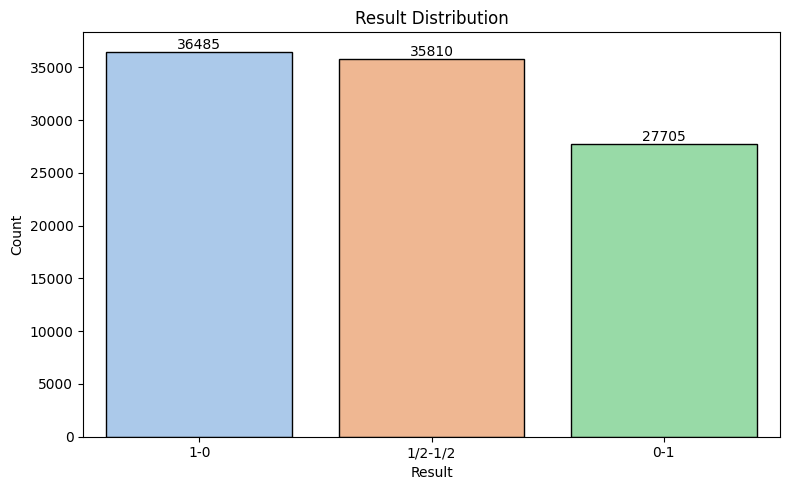

In [70]:
#A labeled bar chart of the result distribution


plt.figure(figsize=(8, 5))

data=df['result'].value_counts().index
values=list(df['result'].value_counts())
ax = sns.barplot(x=data,y=values,palette='pastel', edgecolor='black')

# Add labels on top of bars
for i, row in enumerate(data):
    ax.text(i, float(values[i])+ 0.1, values[i], ha='center', va='bottom')

# Titles and labels
plt.title('Result Distribution')
plt.xlabel('Result')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preparation

In [73]:
#Retain only the following 6 columns
new_df=df[['w.mat.mean', 'b.mat.mean', 'w.mob.mean', 'b.mob.mean', 'half.moves', 'result']].copy()

new_df.head()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves,result
0,28.166667,28.135417,39.312500,27.125000,95,1-0
1,33.851852,33.703704,37.185185,33.074074,53,1-0
2,31.301587,31.920635,32.625000,37.451613,62,0-1
3,21.878261,23.260870,27.172414,32.035088,114,0-1
4,34.775510,34.959184,41.040000,32.958333,48,1/2-1/2


In [82]:
#Looking for nul values and empty values
for cols in new_df.columns:
    print(new_df[cols].loc[new_df[cols].isna()==True])
    

Series([], Name: w.mat.mean, dtype: float64)
Series([], Name: b.mat.mean, dtype: float64)
Series([], Name: w.mob.mean, dtype: float64)
Series([], Name: b.mob.mean, dtype: float64)
Series([], Name: half.moves, dtype: int64)
Series([], Name: result, dtype: int64)


In [84]:
#Print the shape of new data
new_df.shape

(100000, 6)

In [ ]:
#Look for the data characteristics
new_df.describe()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves,result
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.471540,29.456648,33.083914,30.808188,80.524530,1.081050
std,5.700711,5.722296,4.899840,4.488267,33.794235,0.792835
min,7.768683,9.127049,11.312500,12.272727,6.000000,0.000000
25%,25.206546,25.148607,29.653061,27.731616,58.000000,0.000000
50%,30.317267,30.308824,33.390244,31.000000,77.000000,1.000000
75%,34.000000,34.017938,36.700000,33.978723,100.000000,2.000000
max,39.000000,39.000000,50.842105,48.250000,369.000000,2.000000


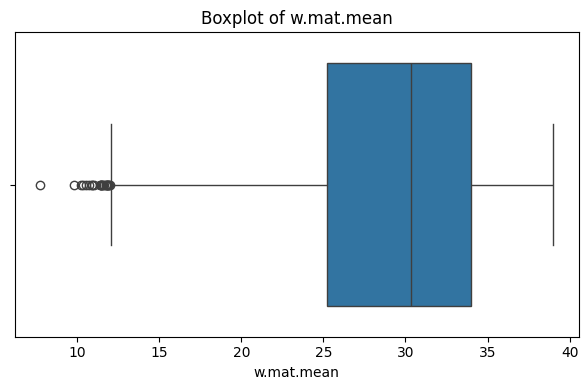

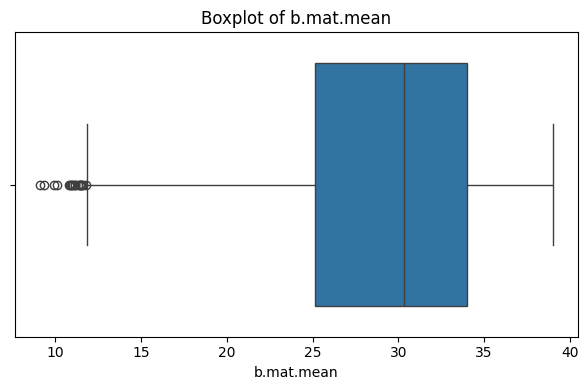

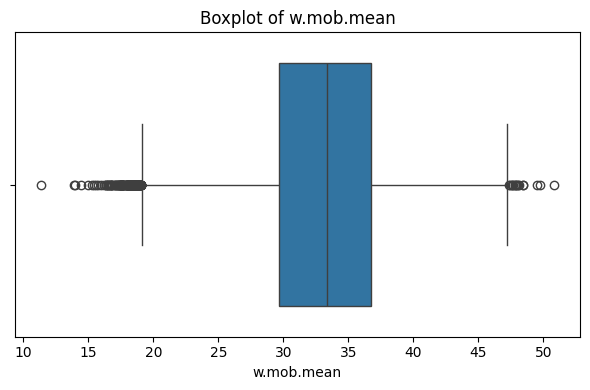

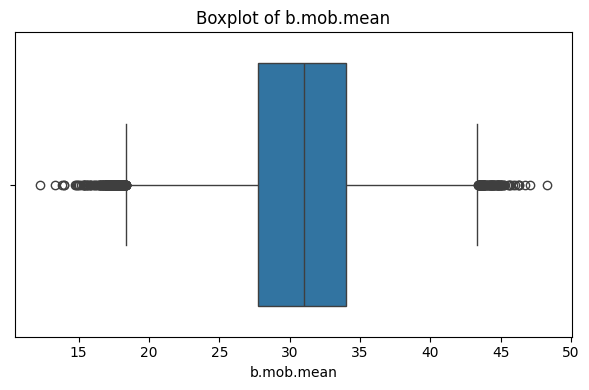

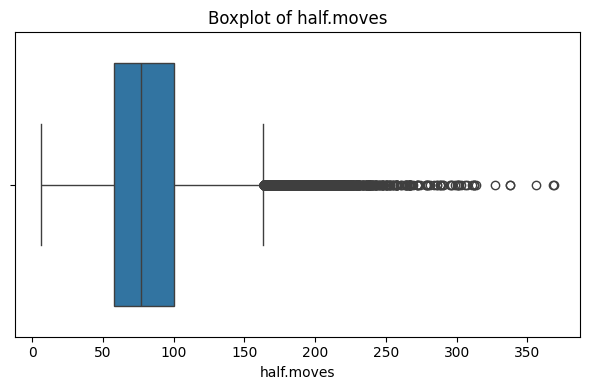

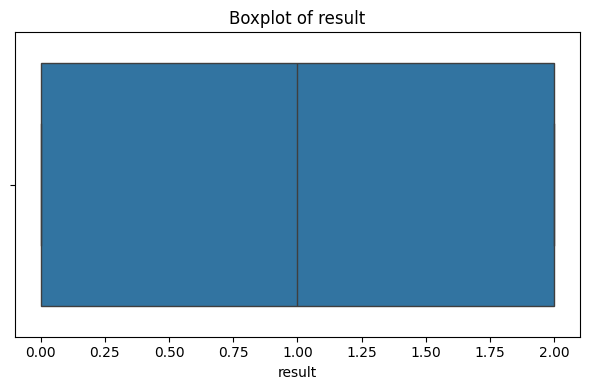

In [ ]:
# looking for how the data is spread

for cols in new_df.columns:
    plt.figure(figsize=(6, 4))  # Create a new figure for each boxplot
    sns.boxplot(data=new_df, x=cols)
    plt.title(f'Boxplot of {cols}')
    plt.tight_layout()
    plt.show()

Looks like the data is spread too much and this needs to be scaled.

In [88]:
#Encode result to numeric using the following mapping
new_df.result=new_df.result.map({'1-0':1, '0-1':0, '1/2-1/2':2})

In [94]:
# Perform an 85% training / 15% test split using train_test_split()
#Train test split
X_train,X_test,y_train,y_test =train_test_split(new_df.drop('result',axis=1),df['result'],test_size=0.15)

In [ ]:
# Scale the 5 numeric predictor columns using StandardScaler()
scalar=StandardScaler()

X_train=scalar.fit_transform(X_train)
X_test=scalar.transform(X_test)

In [ ]:
# Setting up the Dataset and the Data Loader

class CustomDataSet(Dataset):
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype==torch.long)
    def __len__(self):
        return len( self.features)
    
    def __getitem__(self, index):
        return(self.features[index],self.labels[index])

train_dataset=CustomDataSet(X_train,y_train)
test_dataset=CustomDataSet(X_test,y_test)